# Exercise - Unconstrained Optimization

## Data

All the analysis below applies to the data set,
* `data/spx_weekly_returns.xlsx`
* The file has **weekly** returns.
* For annualization, use 52 periods per year.

Consider only the following 10 stocks...

In [ ]:
TICKS =  ['AAPL','NVDA','MSFT','GOOGL','AMZN','META','TSLA','AVGO','BRK/B','LLY']

As well as the ETF,

In [ ]:
TICK_ETF = 'SPY'

### Data Processing

In [ ]:
import pandas as pd

In [ ]:
INFILE = '../data/spx_returns_weekly.xlsx'
SHEET_INFO = 's&p500 names'
SHEET_RETURNS = 's&p500 rets'
SHEET_BENCH = 'benchmark rets'

FREQ = 52

In [ ]:
info = pd.read_excel(INFILE,sheet_name=SHEET_INFO)
info.set_index('ticker',inplace=True)
temp_mkt_cap = info.loc[TICKS].copy()
temp_mkt_cap['mkt cap'] /= 1e9
temp_mkt_cap.rename(columns={'mkt cap':'mkt cap (billions $)'},inplace=True)
temp_mkt_cap.style.format({'mkt cap (billions $)':'{:,.0f}'})

,name,mkt cap (billions $)
ticker,,
AAPL,Apple Inc,"3,009"
NVDA,NVIDIA Corp,"3,480"
MSFT,Microsoft Corp,"3,514"
GOOGL,Alphabet Inc,"2,146"
AMZN,Amazon.com Inc,"2,304"
META,Meta Platforms Inc,"1,745"
TSLA,Tesla Inc,994
AVGO,Broadcom Inc,"1,149"
BRK/B,Berkshire Hathaway Inc,"1,064"


In [ ]:
rets = pd.read_excel(INFILE,sheet_name=SHEET_RETURNS)
rets.set_index('date',inplace=True)
rets = rets[TICKS]

In [ ]:
bench = pd.read_excel(INFILE,sheet_name=SHEET_BENCH)
bench.set_index('date',inplace=True)
rets[TICK_ETF] = bench[TICK_ETF]

***

# 1. Risk Statistics

### 1.1.

Display a table with the following metrics for each of the return series.

* mean (annualized)
* volatility (annualized)
* Sharpe ratio (annualized)
* skewness
* kurtosis
* maximum drawdown

#### Note
We  have total returns, and Sharpe ratio is technically defined for excess returns. Don't worry about the difference. (Or subtract `SHV` if you prefer.)

### 1.2.

As a standalone investment, which is most attractive? And least? Justify your answer.

### 1.3.

For each investment, estimate a regression against `SPY`. Report the 
* alpha (annualized as a mean)
* beta
* info ratio
* r-squared

Based on this table, which investment seems most attractive relative to holding `SPY`?

***

In [ ]:
import numpy as np
pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

In [ ]:
from cmds.portfolio import performanceMetrics, maximumDrawdown, get_ols_metrics
from cmds.risk import *

### **<span style="color:red">Solution 1.1.</span>**

In [ ]:
mets = performanceMetrics(rets,annualization=FREQ)
mets['skewness'] = rets.skew()
mets['kurtosis'] = rets.kurtosis()
mets['max drawdown'] = maximumDrawdown(rets)['Max Drawdown']
mets.style.format('{:.1%}')

,Mean,Vol,Sharpe,Min,Max,skewness,kurtosis,max drawdown
AAPL,23.9%,27.7%,86.3%,-17.5%,14.7%,-21.9%,182.6%,-34.6%
NVDA,64.6%,46.3%,139.3%,-20.1%,30.2%,34.5%,138.9%,-65.9%
MSFT,26.1%,24.0%,108.9%,-14.4%,15.0%,7.2%,234.2%,-35.1%
GOOGL,21.7%,28.0%,77.5%,-12.0%,25.8%,58.3%,372.1%,-41.9%
AMZN,29.3%,30.6%,95.9%,-14.5%,18.5%,6.3%,178.2%,-54.8%
META,26.2%,35.1%,74.6%,-23.7%,24.5%,5.2%,402.4%,-76.0%
TSLA,47.0%,58.6%,80.1%,-25.9%,33.3%,54.8%,159.4%,-72.2%
AVGO,39.5%,37.5%,105.3%,-18.3%,25.2%,66.2%,350.4%,-40.0%
BRK/B,13.5%,19.1%,70.8%,-13.4%,9.8%,-20.1%,251.3%,-26.5%
LLY,28.2%,28.3%,99.5%,-12.2%,17.5%,21.6%,168.3%,-25.3%


### **<span style="color:red">Solution 1.2.</span>**

As a standalone investment, `NVDA` has
* the best Sharpe, which is the best vol-adjusted return.
* large **positive** skewness which is attractive.
* large kurtosis, which would be bad with negative skewness but is appealing with positive skewness.
* a large max drawdown.

If worried about the max drawdown, `LLY` may be a good choice.
* smallest max drawdown
* still has 4th hgihest Sharpe.

### **<span style="color:red">Solution 1.3.</span>**

In [ ]:
get_ols_metrics(rets['SPY'],rets,FREQ).style.format('{:.1%}',na_rep='-')

,alpha,SPY,r-squared,Treynor Ratio,Info Ratio
AAPL,9.3%,111.3%,47.3%,21.4%,46.1%
NVDA,41.8%,173.5%,41.0%,37.2%,117.4%
MSFT,12.6%,103.2%,54.0%,25.3%,77.4%
GOOGL,7.7%,106.6%,42.4%,20.3%,36.2%
AMZN,15.3%,106.6%,35.5%,27.5%,62.4%
META,11.1%,114.8%,31.2%,22.8%,38.2%
TSLA,23.8%,176.2%,26.4%,26.7%,47.4%
AVGO,21.7%,135.7%,38.2%,29.1%,73.5%
BRK/B,2.8%,81.7%,53.6%,16.5%,21.4%
LLY,19.9%,62.7%,14.3%,44.9%,76.1%


Based on this table, `NVDA` is the most attractive. It not only has (by far) the highest alpha, but also the highest Info Ratio (which is the risk-adjusted alpha.)

### **<span style="color:red">Solution .</span>**

In [ ]:
get_ols_metrics(rets[['SPY','NVDA']],rets[['AAPL']],FREQ).style.format('{:.1%}',na_rep='-')

,alpha,SPY,NVDA,r-squared,Info Ratio
AAPL,7.1%,102.2%,5.3%,47.7%,35.3%


For every $100 in `AAPL`, we would short 97.9 dollars of `SPY` and short 7.4 dollars of `NVDA`.

### **<span style="color:red">Solution 1.5.</span>**

The r-squared indicates how highly correlated our replication is to the target.

***

# 2. Portfolio Allocation

### 2.1.

Display the correlation matrix of the returns.

* Based on this information, which investment do you anticipate will get extra weight in the portfolio, beyond what it would merit for its mean return?

* Report the maximally correlated assets and the minimally correlated assets.

### 2.2.

Calculate the weights of the mean-variance optimized portfolio, also called the tangency portfolio.

* Display a table indexed by each investment, with the optimal weights in one column and the Sharpe ratios in another column.

* Do the investments with the best Sharpe ratios tend to get the biggest weights?

#### Note:
To estimate the optimal weights, consider using the provided function below.

In [ ]:
def optimized_weights(returns,dropna=True,scale_cov=1):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()

    if returns.mean() @ weights < 0:
        weights = -weights

    return pd.DataFrame(weights, index=returns.columns)

### 2.3.

Report the following performance statistics of the portfolio achieved with the optimized weights calculated above.
* mean
* volatility
* Sharpe

(Annualize all three statistics.)

### 2.4.

Try dropping the asset which had the biggest short position from the investment set. Re-run the optimization. What do you think of these new weights compared to the original optimized weights?

What is going on?

****

### **<span style="color:red">Solution 2.1</span>**

(<Figure size 1200x1200 with 2 Axes>,
 <Axes: title={'center': 'Correlation matrix (lower triangle)'}>)

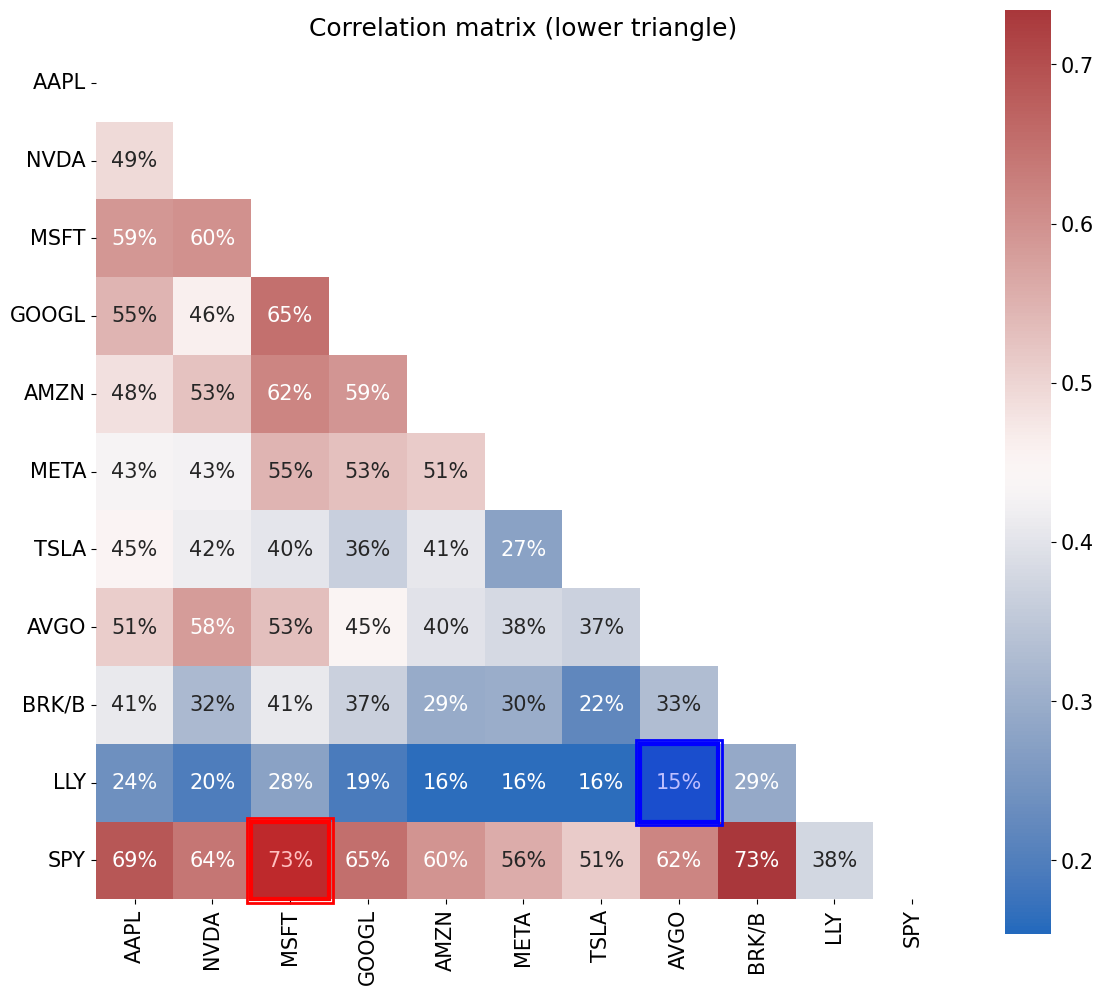

In [ ]:
from cmds.plot_tools import plot_corr_matrix
plot_corr_matrix(rets,triangle='lower',figsize=(12,12))

### **<span style="color:red">Solution 2.2</span>**

In [ ]:
wts = pd.DataFrame(index=rets.columns)
wts['optimized weights'] = optimized_weights(rets)

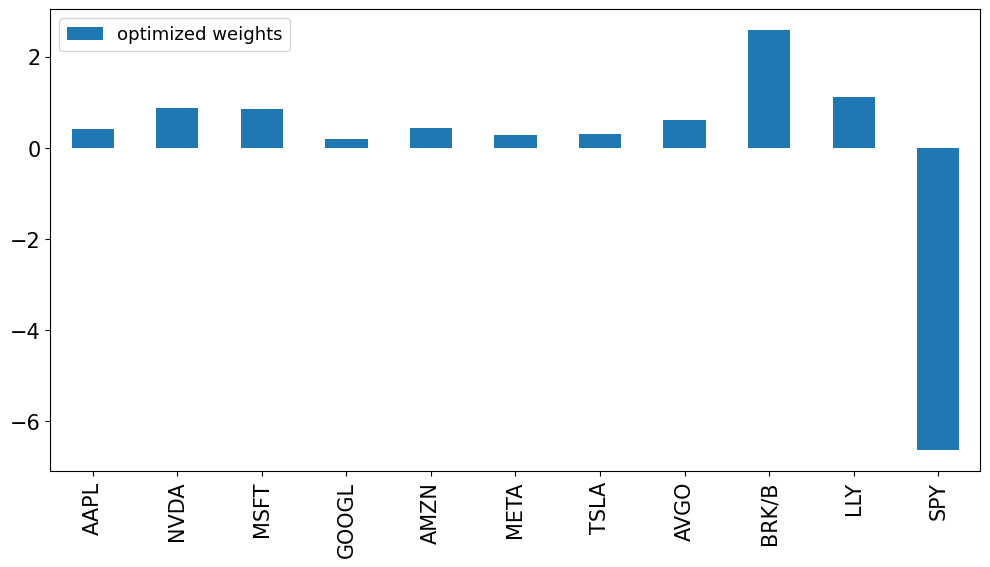

In [ ]:
wts.plot.bar();

In [ ]:
sharpe_vs_wts = pd.concat([wts['optimized weights'],mets['Sharpe']],axis=1)
sharpe_vs_wts.sort_values('optimized weights',ascending=False).style.format('{:.1%}')

,optimized weights,Sharpe
BRK/B,258.0%,70.8%
LLY,111.3%,99.5%
NVDA,88.3%,139.3%
MSFT,84.9%,108.9%
AVGO,60.2%,105.3%
AMZN,42.6%,95.9%
AAPL,40.9%,86.3%
TSLA,31.0%,80.1%
META,27.7%,74.6%
GOOGL,19.3%,77.5%


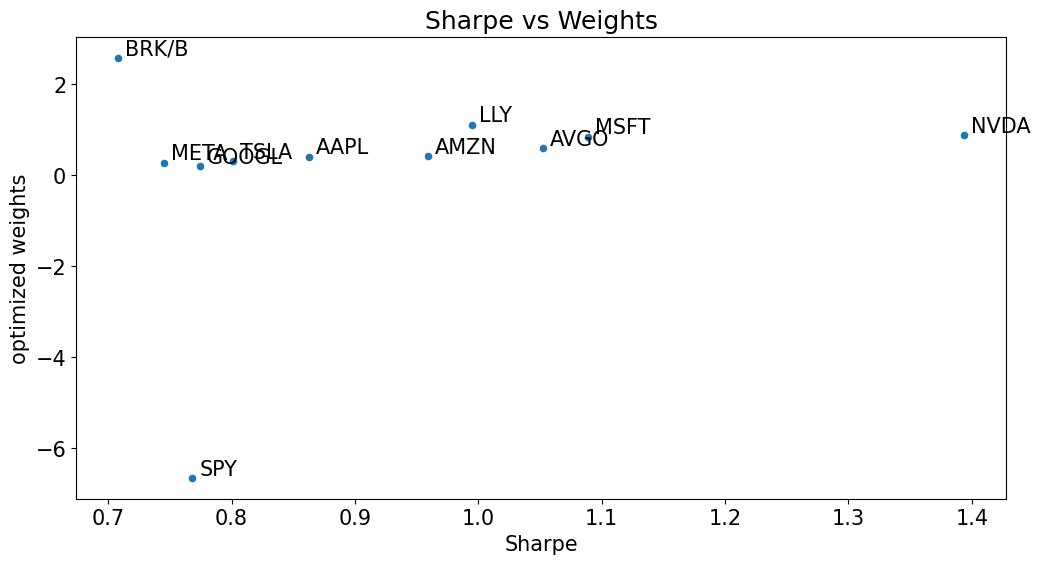

In [ ]:
sharpe_vs_wts.plot.scatter(x='Sharpe',y='optimized weights')


for idx in sharpe_vs_wts.index:
    x_value = sharpe_vs_wts.loc[idx, "Sharpe"]
    y_value = sharpe_vs_wts.loc[idx, "optimized weights"]
    
    plt.annotate(
        text=idx,               
        xy=(x_value, y_value),  
        xytext=(5, 2),          
        textcoords="offset points"
    )

plt.xlabel("Sharpe")
plt.ylabel("optimized weights")
plt.title("Sharpe vs Weights")
plt.show()

### **<span style="color:red">Solution 2.3</span>**

In [ ]:

port = pd.DataFrame(rets @ wts['optimized weights'],columns=['optimized weights'])
performanceMetrics(port,annualization=FREQ).style.format('{:.2%}')

,Mean,Vol,Sharpe,Min,Max
optimized weights,130.22%,62.95%,206.85%,-27.41%,32.35%


### **<span style="color:red">Solution 2.4</span>**

The optimization is unrealistic in that it prescribes massive positions.
* `SPY` is short nearly 600%.
* `BRK-B` is long nearly 200%.

### **<span style="color:red">Solution 2.5</span>**


The optimizer is shorting `SPY` because...
* it has lower mean return than the tech stocks (`NVDA`) 
* it is highly correlated to the tech stocks and can offset much of their risk.

The optimizer is massively long `BRK`...
* even though `BRK` has the **worst** Sharpe ratio of the investments.
* But `BRK` is highly correlated to `SPY` while having relatively low correlation to tech. Thus it lowers total risk.

***

### Extra: Sensitivity to dropping `SPY`

In [ ]:
DROPTICK = 'SPY'

In [ ]:
wts[f'optimized ex {DROPTICK}'] = optimized_weights(rets.drop(columns=[DROPTICK]))
wts.loc[f'{DROPTICK}',f'optimized ex {DROPTICK}'] = 0

port[f'optimized ex {DROPTICK}'] = pd.DataFrame(rets @ wts[f'optimized ex {DROPTICK}'],columns=[f'optimized ex {DROPTICK}'])

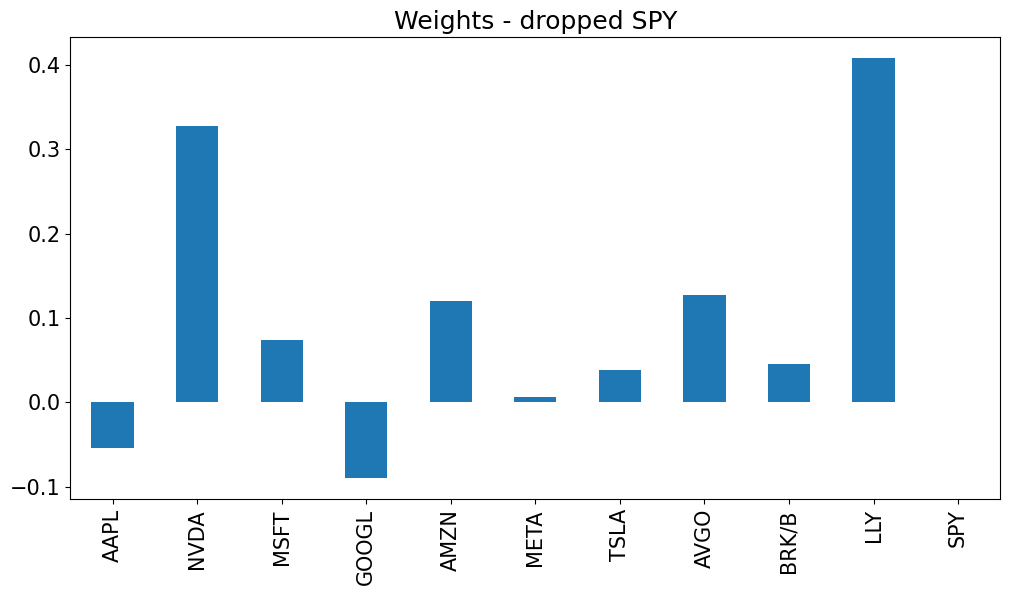

In [ ]:
wts[f'optimized ex {DROPTICK}'].plot.bar();
plt.title(f'Weights - dropped {DROPTICK}');

These weights are much more realistic. They are reasonable magnitudes and don't include massive short positions.

Without `SPY`, the correlation matrix has relatively low correlations. Thus, the optimizer doesn't think it can achieve such balanced (hedged) offsets, so it doesn't prescribe extremes. 

In [ ]:
performanceMetrics(port,annualization=FREQ).style.format('{:.1%}')

,Mean,Vol,Sharpe,Min,Max
optimized weights,130.2%,63.0%,206.9%,-27.4%,32.3%
optimized ex SPY,42.4%,26.2%,161.6%,-11.9%,15.2%


In [ ]:
wts.abs().sum().to_frame('gross mkt weight').style.format('{:,.1%}')

,gross mkt weight
optimized weights,"1,428.6%"
optimized ex SPY,128.9%
